![](./assets/header-logo.png)

## *Simulation-Based Performance Study of Semantic Image Segmentation*

**Automated and Connected Driving Challenges - Research Project - *09/2024***

**Research Topic *14: Simulation-Based Performance Study of Semantic Image Segmentation***

| Author | Mail |
| --- | --- |
| Mohammad Talha Bin Noman | talha.noman@rwth-aachen.de |
| Shengyao Jiang | shengyao.jiang@rwth-aachen.de |


#### Dependencies & Setup

##### Execution Environment
To run this notebook:

- python3

To run the entire project:

- Linux OS, e.g. Ubuntu
- Nvidia GPU, gRAM >=8G
- Docker
    

##### Dependencies
Installed below

In [1]:
# === INSTALLATION OF PYTHON DEPENDENCIES ==========================

import sys

# --- installation via pip -----------------------------------------

# install packages via pip (version numbers should be included to guarantee reproducibility)
!{sys.executable} -m pip install \
absl-py==2.1.0 \
aggdraw==1.3.18.post0 \
altair==5.4.1 \
astunparse==1.6.3 \
attrs==24.2.0 \
blinker==1.8.2 \
cachetools==5.5.0 \
certifi==2024.7.4 \
charset-normalizer==3.3.2 \
click==8.1.7 \
contourpy==1.2.1 \
cycler==0.12.1 \
fastjsonschema==2.20.0 \
flatbuffers==24.3.25 \
fonttools==4.53.0 \
gast==0.6.0 \
gitdb==4.0.11 \
GitPython==3.1.43 \
google-pasta==0.2.0 \
grpcio==1.64.1 \
h5py==3.11.0 \
idna==3.7 \
Jinja2==3.1.4 \
joblib==1.4.2 \
jsonschema==4.23.0 \
jsonschema-specifications==2023.12.1 \
keras==3.4.1 \
kiwisolver==1.4.5 \
libclang==18.1.1 \
Markdown==3.6 \
markdown-it-py==3.0.0 \
MarkupSafe==2.1.5 \
matplotlib==3.9.1 \
mdurl==0.1.2 \
ml-dtypes==0.3.2 \
namex==0.0.8 \
narwhals==1.6.2 \
nbformat==5.10.4 \
numpy==1.26.4 \
openvino==2024.3.0 \
openvino-telemetry==2024.1.0 \
opt-einsum==3.3.0 \
optree==0.12.0 \
pandas==2.2.2 \
pillow==10.4.0 \
plotly==5.24.0 \
protobuf==4.25.3 \
pyarrow==17.0.0 \
pydeck==0.9.1 \
pyparsing==3.1.2 \
pytz==2024.1 \
pywin32==305.1 \
referencing==0.35.1 \
requests==2.32.3 \
rich==13.7.1 \
rpds-py==0.20.0 \
scikit-learn==1.5.1 \
scipy==1.14.0 \
seaborn==0.13.2 \
setuptools==69.5.1 \
smmap==5.0.1 \
streamlit==1.38.0 \
tenacity==8.5.0 \
tensorboard==2.16.2 \
tensorboard-data-server==0.7.2 \
tensorflow==2.16.2 \
tensorflow-intel==2.16.2 \
termcolor==2.4.0 \
threadpoolctl==3.5.0 \
toml==0.10.2 \
typing_extensions==4.12.2 \
tzdata==2024.1 \
urllib3==2.2.2 \
visualkeras==0.1.3 \
watchdog==4.0.2 \
Werkzeug==3.0.3 \
wheel==0.43.0 \
wrapt==1.16.0 \

# === INSTALLATION OF OTHER SYSTEM DEPENDENCIES ====================
# Note that these may require admin privileges.
# You can pipe the password to 'sudo' by echoing it and running 'sudo -S', see below.

# --- installation of system dependencies via apt ------------------
#!echo "jovyan" | sudo -S apt update
#!echo "jovyan" | sudo -S apt install -y ros-noetic-sensor-msgs

# --- installation of ROS dependencies via rosdep ------------------
# !rosdep install -y --ignore-src --from-paths src



To install the CARLOS, use [this](https://github.com/ika-rwth-aachen/carlos) link.

In [2]:

import os
import re
import glob
import random
import datetime
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
from sklearn.metrics import jaccard_score as jsc
from sklearn.metrics import confusion_matrix

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Plotting libraries
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import plotly.express as px
import plotly.graph_objects as go

# IPython display utilities
from IPython.display import display, Image

# TensorFlow Keras layers and model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Input, Dense, Conv2D, Conv2DTranspose, MaxPooling2D,
                                     BatchNormalization, Dropout, Activation, Concatenate)

# Custom utilities for segmentation
from segmentation_utils.metrics import SparseMeanIoU
from segmentation_utils.image_segmentation_utils import *


#### Abstract

This research presents a simulation-based performance study of an image segmentation model, utilizing the Carlos platform for synthetic data generation. The study focuses on training a U-Net model with a depth of five layers to evaluate how domain shifts—specifically variations in weather conditions, pedestrian density, and on-road vehicle density affect segmentation performance. Semantic image segmentation is a very crucial task in computer vision, where precise pixel-level classification is required for applications like autonomous driving. However, real-world datasets often suffer from limitations in diversity and scalability, which can impact the model's generalization to different environments and scenarios.

By leveraging the Carlos platform, we generate synthetic datasets which systematically introduce environmental variations. We then analyse the U-Net model's performance across different scenarios, assessing how domain shifts impact the accuracy and robustness of segmentation. The study reveals that weather conditions, as well as variations in pedestrian and vehicle density as well as changes in weather and location, can degrade model performance. However, by far, the largest performance drop is observed in the case of changes in location. This work highlights the importance of simulation-based data generation in addressing the challenges posed by real-world variability in semantic image segmentation tasks.


### Introduction

Perception is an important component of an autonomous driving system, which refers to the ability of an autonomous driving system to perceive its surroundings through various sensors, including recognizing and understanding elements such as roads, vehicles, pedestrians, and obstacles. Based on different sensors and different stages of data processing, the automatic driving perception task can be divided into several sub-tasks, such as semantic segmentation, target detection, motion pattern recognition, etc., thus providing a basis for the system's planning and control decisions. "The goal of semantic segmentation is to segment the input image according to semantic information and predict the semantic category of each pixel from a given label set." [[1]](https://www.sciencedirect.com/science/article/pii/S0925231222000054)。Depending on the sensor, semantic segmentation is mainly categorized into LiDAR-based semantic segmentation and vision-based semantic segmentation, this article is concerned with visual semantic segmentation. As with many machine learning methods, vision-based semantic segmentation methods also face the problem of domain shift. Domain shift refers to the phenomenon where the data distribution used to train a machine learning model differs from the data distribution encountered during actual application (testing). This distribution discrepancy can cause the model to perform well on the training set but experience a decline in performance when applied in real-world scenarios. Typical problems caused by domain shift in autonomous driving scenarios are, for example, that a model trained in a rural scenario does not perform well in an urban scenario, and that a classifier trained in a sunny scenario does not perform well in a rainy scenario.

Although researchers seem to agree on the concept of domain shift, due to the complexity of the display world, it is not possible to be as precise in describing every domain as in describing mathematical distributions. In reality, many domains do not have clear boundaries between them and are intertwined. For example, driving from the centre of the city to the edge of the city, the surrounding scene changes gradually rather than suddenly. Therefore, we raise two questions:

- a) Is there some kind of “correlation” from one domain to another? To be more specific, the relationship between rural, small town, and urban is a progressive one in terms of the concept of urbanization. If a model A is trained on a dataset containing both countryside and urban scenarios, it can be hypothesized that it could adapt to suburban areas which have elements from both the domains combined. Additionally, does a model which is trained on the mid rainy scenario perform at the same level in a hard rain and soft rain scenario? *

- b) If the answer to question a) is “no”, can we determine some kind of optimal domain partitioning for training a model for autonomous driving so that the amount of data required to train a compliant model which achieves the required performance is minimized? *

Currently many autonomous driving companies collect their own datasets to train autonomous driving algorithms, the vast majority of which are kept strictly confidential. There are some companies that publish their own datasets, such as Waymo Open Dataset [[2]](https://openaccess.thecvf.com/content_CVPR_2020/html/Sun_Scalability_in_Perception_for_Autonomous_Driving_Waymo_Open_Dataset_CVPR_2020_paper.html) from Waymo and ApolloScape [[3]](https://openaccess.thecvf.com/content_cvpr_2018_workshops/w14/html/Huang_The_ApolloScape_Dataset_CVPR_2018_paper.html) from Baidu. These datasets often require a large amount of manual labelling of the dataset, which entails a high economic cost, and the training process also often consumes a lot of energy and generates carbon emissions, which also creates a burden for the environment. We, the authors, believes that researching the questions raised in the previous paragraphs can provide a basis for the generation of datasets and the scale of model training to overcome the domain shift for autonomous driving models, to achieve the purpose of saving the economic and environmental costs.

This report discusses mainly about the question a). We first generate the train dataset by controlling domain variables such as city, weather, number of pedestrians, number of vehicles, etc. Then, a U-Net model is trained on the generated dataset. Finally, the U-Net model is tested validation datasets which have been generated with domain shifts included in it. The main findings of this research are documented below:
1. In this research, it was observed that across the board, there was a decline in model performance due to shifts in weather conditions, pedestrian numbers, vehicle occupancies, and environment. 
2. Another important finding was that shifts in the location like shifts from urban to suburban conditions led to sharp declines in model performance in the range of about 40% which underscore's their effect on model performance while for the other types of domain shifts, performance drops were observed but they were not nearly as large usually between 4% and 10%.


### Related Work

When an image segmentation model is trained on some data. The domain of that specific image segmentation model refers to the distribution of the training data. For example, if the model is trained on urban data, the domain of the model will be urban scenarios. So, domain shift, in other words, is a high-level concept to understand the underlying domain representations that a model learns. If a model encounters some data that does not follow the distribution of the training data, it is said to have encountered domain shift as its internal representation that it has learned over the course of its training is not well suited to the segmentation of the domain shifted image. Over the past few years there have been increases in attempts to learn about the nature of domain shift and its effect on model performance.

Domain shifts as they are explained in [[6]](https://openaccess.thecvf.com/content/CVPR2022/papers/Sun_SHIFT_A_Synthetic_Driving_Dataset_for_Continuous_Multi-Task_Domain_Adaptation_CVPR_2022_paper.pdf) are generally classified into two main types, discrete and continuous shifts. Discrete shifts refer to the domain shifts which are in homogeneous sets. As an example, one set can have clear weather while another set can have rainy weather. Continuous domain shifts on the other hand have intra-sequence shifts from one domain to another. For example, one set can contain images that show clear weather changing into rainy weather.

To study domain shifts, deep learning studies need to be based on precisely labelled datasets. Faced with the problem that manually labelled data generation is generally slow and costly, some synthetic datasets have been proposed. For example, GTA V Dataset [[4]](https://download.visinf.tu-darmstadt.de/data/from_games/) was a synthetic dataset which had no labels for domain shift which made it an unfavourable dataset to understand the nature of domain shifts. Additionally, SYNTHIA Dataset [[5]](https://ieeexplore.ieee.org/document/7780721) was a synthetic dataset which contained images from discrete domain shifts like discrete changes in weather, location etc. Additionally, Sun et al. [[6]](https://openaccess.thecvf.com/content/CVPR2022/papers/Sun_SHIFT_A_Synthetic_Driving_Dataset_for_Continuous_Multi-Task_Domain_Adaptation_CVPR_2022_paper.pdf) designed the SHIFT dataset. The SHIFT dataset has about 2.5 million labelled images from both discrete and continuous domain shifts. 

However, the downside of the datasets discussed above are their static nature. There is little room for custom dataset generation targeting specific domains which is where the simulation based methods come into play. Geller et al. proposed the CARLOS framework [[7]](https://ieeexplore.ieee.org/document/10588502) which is a simulation suite which can quickly generate datasets with multi specified domain variables according to the users' needs, providing a high degree of freedom in dataset generation for researchers in domain shift field. This allows the user to generate targeted domain specific datasets to investigate the effects of certain domain shifts on model performance.



### Methodology

Image segmentation is a very important task in the space of computer vision. It has many applications in fields like medical imaging, autonomous driving, etc. To conduct image segmentation a multitude of models are utilized. One of the many models being used is the U-Net model which is particularly good at segmentation of images as it can capture spatial hierarchies and fine details easily. In our project, to analyse the performance of a model using synthetic datasets, we first need to train said model and for that, we have chosen the U-Net architecture because of its simple design and relatively low compute requirements.

Before we talk about the model architecture that we are going to use let’s talk a little about the inputs to the model.

#### Data Preperation

##### Data generation and annotation
We first built a new docker image based on the original image provided by CARLOS. As standard, the stock image does not have some maps which need to be manually added. For the specific process on how to add such maps, please check the following section on how to add the extra maps into CARLOS. 

Next, rosbag data was generated using CARLOS's [data-driven development](.\CARLOS\carlos\data-driven-development\README.md) use case. The readme file has instructions on how to generate the simulation files which can be followed for dataset generation.

Each rosbag data package contains a stream of time-synchronized rgb camera images as well as a stream of the groudtruth semantic segmentation map. The images from these streams are extracted using a specially created [python script](.\rosbag_extractor.py). This script aligns the images according to the timestamps and saves them in the directory structure required. The instructions to use the script are included in it.


##### How to add the extra maps into carlos



Town06 (highway) and Town07 (rural) are additional maps that do not come as standard with the CARLA package. So, to generate datasets which use these maps, using CARLOS, some additional steps are required.

Step 1. Start the container by cd-ing into the carlos folder and running the following command.

`./run-demo.sh software-prototyping `

Step 2. To check if the container is running and find out the container id of the container rwthika/carla-simulator:server

`docker ps -a`

Step 3. Get inside the docker container, here the "c3e6497dcd33" is the container id from Step 2

`docker exec -it c3e6497dcd33 /bin/bash` 

Step 4. Download the additional maps and install them

```
carla@c3e6497dcd33:~$ cd Import
carla@c3e6497dcd33:~/Import$ wget https://carla-releases.s3.us-east-005.backblazeb2.com/Linux/AdditionalMaps_0.9.15.tar.gz
carla@c3e6497dcd33:~/Import$ cd
carla@c3e6497dcd33:~$ ./ImportAssets.sh
```
Step 5. Commit the running container as a new image

`docker commit c3e6497dcd33  carla_additional:server`

Step 6. Change the components.yml in the directory carlos/utils.Change the image name with the name of the image you just saved in Step 5

![componets.yml](./assets/components.yml.png)

Step 7. Comment the 61st line of the data_generation.py

![data_generation](./assets/data_generation.png)

Step 8. Then you can modify the json and generate the data as normal

![data-driven-development-demo-image-segmentation.json](./assets/data-driven-development-demo-image-segmentation.json.png)


##### Data loading and preprocessing
Once the dataset is generated, to load the whole dataset, we will use the `os` module of python to walk the directory that has the dataset stored and then store the paths to all the training data and the labels in lists named images_path and labels_path. We will also be shuffling the paths so that when we split the dataset into the training and test sets, they have a favourable distribution of the images from all of the different synthetic datasets and no specific dataset has heavy representation in the test dataset so that we have a good understanding of the model performance while it is being trained. To load the dataset and split it into test and train sets as required we can use the following function:

In [3]:
def getPaths(test_train_split_bool=True, test_train_split=0.7, folder_path=None):
    """
    Retrieves file paths for images and labels from a combined folder structure, 
    where images are stored in 'x' subfolders and labels in 'y' subfolders.
    
    The function then shuffles the dataset and splits it into training and test sets based on the given ratio.

    Parameters:
    test_train_split (float): The ratio for the train-test split. Default is 0.7 (70% train, 30% test).

    Returns:
    train_images (list): List of file paths for training images.
    train_labels (list): List of file paths for training labels.
    test_images (list): List of file paths for testing images.
    test_labels (list): List of file paths for testing labels.
    """
    if folder_path==None:
        base_path = os.getcwd()  # Get the current working directory
        folder_path = os.path.join(base_path, 'combined')  # Set the path to the 'combined' folder
    else:
        folder_path = folder_path
    
    images_path = []  # List to store image file paths
    labels_path = []  # List to store label file paths
    
    # Walk through the folder structure and collect image file paths from 'x' subfolders
    for foldername, subfolders, filenames in os.walk(folder_path):
        folder_names = foldername.split("\\")
        if folder_names[-1] == 'x':
            for filename in filenames:
                file_path = os.path.join(foldername, filename)
                images_path.append(file_path)
    
    # Walk through the folder structure and collect label file paths from 'y' subfolders
    for foldername, subfolders, filenames in os.walk(folder_path):
        folder_names = foldername.split("\\")
        if folder_names[-1] == 'y':
            for filename in filenames:
                file_path = os.path.join(foldername, filename)
                labels_path.append(file_path)

    # Shuffle the dataset by combining images and labels into pairs and randomizing the order
    fused_list = list(zip(images_path, labels_path))  # Combine images and labels into pairs
    random.shuffle(fused_list)  # Shuffle the pairs
    

    # Unzip the shuffled list back into separate image and label paths
    images_path, labels_path = map(list, zip(*fused_list))

    # Calculate the number of training samples based on the split ratio
    length = len(images_path)
    train_size = int(test_train_split * length)  # Determine training set size
    if test_train_split_bool== True:
        # Split the data into training and testing sets
        train_images = images_path[:train_size]
        train_labels = labels_path[:train_size]
        test_images = images_path[train_size:]
        test_labels = labels_path[train_size:]

        return train_images, train_labels, test_images, test_labels
    else:
        return images_path, labels_path



Let’s look at the data that we have. As shown below, the training data has inputs that are images showing what is being observed by the vehicle’s on-board camera while the output is the segmented image with specific RGB values representing each class.


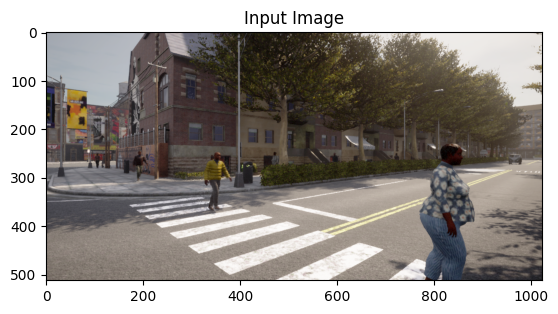

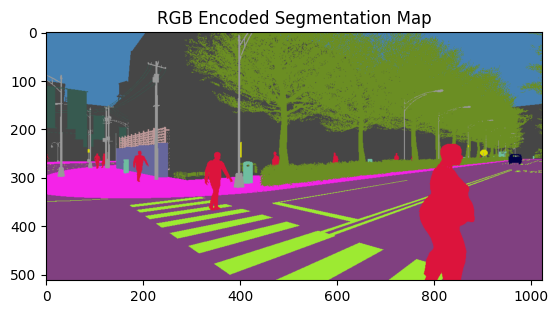

In [4]:
x, y, z, w = getPaths()
img = tf.image.decode_image(tf.io.read_file(x[0]), channels=3)

plt.imshow(img)
plt.title("Input Image")
plt.show()

img1 = tf.image.decode_image(tf.io.read_file(y[0]), channels=3)

plt.imshow(img1)
plt.title("RGB Encoded Segmentation Map")
plt.show()

To make the prediction step easier and more straightforward, we will convert the RGB encoded label to a segmentation class map. A segmentation map is a representation of the output where the RGB values associated with each class are assigned a unique number and the RGB values in the output label are replaced by that unique number. 

For that we use a dictionary and the function like the one shown below.


In [5]:
rgb_to_class_id = {
    (128, 64, 128):  0,   # Road
    (244, 35, 232):  1,   # Sidewalk
    (250, 170, 160): 2,   # Parking
    (230, 150, 140): 3,   # Tail track
    (220,  20,  60): 4,   # Person
    (255,   0,   0): 5,   # Rider
    (  0,   0, 142): 6,   # Car
    (  0,   0,  70): 7,   # Truck
    (  0,  60, 100): 8,   # Bus
    (  0,  80, 100): 9,   # On Rails
    (  0,   0, 230): 10,  # Motorcycle
    (119,  11,  32): 11,  # Bicycle
    (  0,   0,  90): 12,  # Caravan
    (  0,   0, 110): 13,  # Trailer
    ( 70,  70,  70): 14,  # Building
    (102, 102, 156): 15,  # Wall
    (190, 153, 153): 16,  # Fence
    (180, 165, 180): 17,  # Guard Rail
    (150, 100, 100): 18,  # Bridge
    ( 50, 120,  90): 19,  # Tunnel
    (153, 153, 153): 20,  # Pole
    (220, 220,   0): 21,  # Traffic sign
    (250, 170,  30): 22,  # Traffic light
    (107, 142,  35): 23,  # Vegetation
    (152, 251, 152): 24,  # Terrain
    ( 70, 130, 180): 25,  # Sky
    ( 81,   0,  81): 26,  # Ground
    (111,  74,   0): 27,  # Dynamic
    ( 20,  20,  20): 28,  # Static
    (157, 234,  50): 29,  # Road Line
    ( 45,  60, 150): 30,  # Water
    (  0,   0,   0): 31   # None
}

In [6]:
def convert_rgb_encoding_to_segmentation_map(image, rgb_to_class_id):
    """
    Converts an RGB-encoded image into a segmentation map where each pixel is assigned a class ID.

    Arguments:
    image -- A tf.Tensor of shape [height, width, 3], where each pixel contains a tuple of (R, G, B) values.
    rgb_to_class_id -- A dictionary mapping RGB color tuples (as keys) to their respective class IDs (as values).

    Returns:
    segmentation_map -- A tf.Tensor of shape [height, width, 1], where each pixel contains a single integer representing a class ID.
    """
    
    # Initialize an empty segmentation map with the same height and width as the input image
    # The dtype is set to uint8 since class IDs are expected to be small integers
    segmentation_map = tf.zeros([image.shape[0], image.shape[1]], dtype=tf.uint8)

    # Iterate through each color-class_id mapping
    for color, class_id in rgb_to_class_id.items():
        # Check where all RGB channels in the image match the current color tuple
        # tf.reduce_all() ensures that all elements (R, G, B) are equal to the corresponding elements in the 'color' tuple
        # tf.equal() compares the pixel value with the target color
        segmentation_map = tf.where(
            condition=tf.reduce_all(tf.equal(image, color), axis=-1),  # Find pixels that match the RGB color
            x=tf.cast(class_id, tf.uint8),  # Replace matching pixels with the corresponding class_id
            y=segmentation_map  # Keep other pixels unchanged
        )

    # Add a final dimension to the segmentation map to change its shape from [height, width] to [height, width, 1]
    segmentation_map = tf.expand_dims(segmentation_map, axis=-1)
    
    return segmentation_map

Now, a function that takes an input of the image and label paths while returning tensors containing the image and labels can be defined as shown.

In [7]:
def parse_sample(image_path, label_path):
    """
    Parses a sample by loading and processing both an image and its corresponding label.
    
    Arguments:
    image_path -- String, path to the camera image (RGB).
    label_path -- String, path to the label image (RGB encoding for segmentation classes).
    
    Returns:
    image_rgb -- tf.Tensor of shape [512, 1024, 3], containing the resized camera image in RGB format.
    label_segmentation_map -- tf.Tensor of shape [512, 1024, 1], containing the segmentation map where each pixel represents a class.
    """
    
    # Load the camera image from the provided path and decode it as an RGB image (3 channels)
    image_rgb = tf.image.decode_png(tf.io.read_file(image_path), channels=3)
    
    # Load the label image from the provided path and decode it as an RGB image (3 channels)
    label_rgb = tf.image.decode_png(tf.io.read_file(label_path), channels=3)
    
    # Resize the camera image to a standard size [512, 1024] using bilinear interpolation
    # Bilinear resizing smooths the image, which is suitable for camera images
    image_rgb = tf.image.resize(image_rgb, [512, 1024], method=tf.image.ResizeMethod.BILINEAR)
    
    # Resize the label image to the same size [512, 1024] using nearest-neighbor interpolation
    # Nearest-neighbor is used for segmentation labels to preserve integer class values
    label_rgb = tf.image.resize(label_rgb, [512, 1024], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    # The bilinear resize returns a tf.float32 tensor, so we need to cast the camera image back to uint8
    image_rgb = tf.cast(image_rgb, tf.uint8)
    
    # Convert the RGB-encoded label image to a segmentation map using a predefined color-to-class mapping
    # 'rgb_to_class_id' should be a dictionary mapping RGB color tuples to class IDs
    label_segmentation_map = convert_rgb_encoding_to_segmentation_map(label_rgb, rgb_to_class_id)

    
    return image_rgb, label_segmentation_map

As we are using synthetic datasets, we can generate datasets with a wide range of conditions such as datasets containing night-time conditions, rainy conditions, sunny conditions etc. as well as containing different location conditions like rural conditions and urban conditions. Even though we have the freedom to generate all sorts of datasets, not all possible permutations of the conditions can be generated. Therefore, to make sure that the model has enough data to be somewhat generalizable, so that the model performance we observe is of one which has been trained well, we will make use of data augmentation. 

Data augmentation is implemented because in real-world scenarios, often, models are trained using augmentation methods to make sure that they generalize well, however, what we are interested in, is how the performance of a nicely trained model is affected by domain shift. Therefore, we are implementing data augmentation in our data pipeline.

There are many forms of data augmentation. The data augmentation methods that have been used during our model’s training will be explained below.
1. Random flip allows mirror image scenarios to be accounted for.
2. Random gamma allows the change the contrast in a nonlinear fashion when compared to random contrast which is more of a linear alteration.
3. Random brightness should allow the model to generalize well to different times of day.
4. Random contrast allows linear changes in contrast as opposed to non linear ones we introduced through random gamma.
5. Random noise allows us to artificially add noise to the input image thereby increasing the robustness of the model to noise and optic artifacts.
6. Random zoom allows the feature extractor part of the model to more efficiently learn features in an image and increase model robustness.

The functions to implement these augmentations can be created as shown below.


In [8]:
def random_flip(image, label):
    """
    Randomly flips the image-label pair horizontally with a probability of 0.5.
    
    Arguments:
    image -- tf.Tensor with shape [height, width, 3], representing the camera RGB image.
    label -- tf.Tensor with shape [height, width, 1], representing the corresponding segmentation map.
    
    Returns:
    image -- Augmented tf.Tensor of shape [height, width, 3], representing the (possibly flipped) camera RGB image.
    label -- Augmented tf.Tensor of shape [height, width, 1], representing the (possibly flipped) segmentation map.
    """

    # Generate a random scalar between 0 and 1 to determine whether to flip
    random_value = tf.random.uniform(shape=[], minval=0, maxval=1, dtype=tf.float16)
    
    # Use tf.cond to apply horizontal flip if random_value > 0.5, otherwise return original image and label
    (image, label) = tf.cond(
        pred=random_value > 0.5,
        true_fn=lambda: (tf.image.flip_left_right(image), tf.image.flip_left_right(label)),  # Flip both image and label
        false_fn=lambda: (image, label)  # Return original image and label if no flip is applied
        )
    
    return image, label

In [9]:
def random_gamma(image, label):
    """
    Randomly applies gamma correction to the image while leaving the label unchanged.
    
    Arguments:
    image -- tf.Tensor of shape [height, width, 3], representing the camera RGB image.
    label -- tf.Tensor of shape [height, width, 1], representing the corresponding segmentation map.
    
    Returns:
    image -- Augmented tf.Tensor of shape [height, width, 3], representing the gamma-adjusted camera RGB image.
    label -- Unchanged tf.Tensor of shape [height, width, 1], representing the original segmentation map.
    """

    # Generate a random gamma value between 0.3 and 1.2 for augmentation
    random_gamma = tf.random.uniform(shape=[], minval=0.3, maxval=1.2, dtype=tf.float32)
    
    # Apply the gamma correction to the image. Gamma values < 1 darken the image, values > 1 brighten it.
    image = tf.image.adjust_gamma(image, gamma=random_gamma)
    
    # Return the gamma-augmented image and the unchanged label
    return image, label

In [10]:
def random_brightness(image, label):
    """
    Randomly adjusts the brightness of the image while leaving the label unchanged.
    
    Arguments:
    image -- tf.Tensor of shape [height, width, 3], representing the camera RGB image.
    label -- tf.Tensor of shape [height, width, 1], representing the corresponding segmentation map.
    
    Returns:
    image -- Augmented tf.Tensor of shape [height, width, 3], representing the brightness-adjusted RGB image.
    label -- Unchanged tf.Tensor of shape [height, width, 1], representing the original segmentation map.
    """
    
    # Apply a random brightness adjustment to the image.
    # The max delta value (0.4) controls the range of brightness adjustment.
    # The resulting image can be darker (if delta is negative) or brighter (if delta is positive).
    image = tf.image.random_brightness(image, 0.4)

    # Return the augmented image and the unchanged label
    return image, label

In [11]:
def random_contrast(image, label):
    """
    Randomly adjusts the contrast of the image while leaving the label unchanged.
    
    Arguments:
    image -- tf.Tensor of shape [height, width, 3], representing the camera RGB image.
    label -- tf.Tensor of shape [height, width, 1], representing the corresponding segmentation map.
    
    Returns:
    image -- Augmented tf.Tensor of shape [height, width, 3], representing the contrast-adjusted RGB image.
    label -- Unchanged tf.Tensor of shape [height, width, 1], representing the original segmentation map.
    """
    
    # Apply random contrast adjustment to the image.
    # Contrast is randomly adjusted between the lower limit (0.2) and upper limit (1.1).
    # A value less than 1 decreases contrast, while a value greater than 1 increases contrast.
    image = tf.image.random_contrast(image, 0.2, 1.1)
    
    # Return the augmented image and the unchanged label
    return image, label

In [12]:
def random_noise(image, label):
    """
    Randomly applies noise augmentation to the image. The label remains unchanged.
    
    Arguments:
    image -- tf.Tensor of shape [height, width, 3], representing the camera RGB image.
    label -- tf.Tensor of shape [height, width, 1], representing the corresponding segmentation map.
    
    Returns:
    image -- Augmented tf.Tensor of shape [height, width, 3], representing the noise-augmented RGB image.
    label -- Unchanged tf.Tensor of shape [height, width, 1], representing the original segmentation map.
    """
    
    # Generate a random standard deviation for the noise, simulating different levels of noise intensity.
    # The noise level will vary between 2 and 30.
    random_stddev = tf.random.uniform(shape=[], minval=2, maxval=30, dtype=tf.float32)
    
    # Generate a noise tensor with the same shape as the input image. The noise follows a normal distribution
    # with a mean of 0 and a random standard deviation.
    noise = tf.random.normal(tf.shape(image), mean=0.0, stddev=random_stddev, dtype=tf.float32)
    
    # Convert the image to tf.float32 (from tf.uint8) to enable addition of noise.
    image = tf.cast(image, dtype=tf.float32) + noise
    
    # Clip the pixel values of the image to the valid range [0, 255], as pixel values outside this range 
    # are not valid for images.
    image = tf.clip_by_value(image, 0.0, 255.0)
    
    # Convert the image back to tf.uint8 to return it in the correct data type for image tensors.
    image = tf.cast(image, dtype=tf.uint8)

    return image, label

In [13]:
def random_zoom(image, label):
    """
    Randomly applies zoom augmentation to the image-label pair by resizing the image to a random
    scale, then cropping it back to its original size.
    
    Arguments:
    image -- tf.Tensor of shape [height, width, 3], representing the camera RGB image.
    label -- tf.Tensor of shape [height, width, 1], representing the corresponding segmentation map.
    
    Returns:
    image -- Augmented tf.Tensor of shape [height, width, 3], representing the zoomed and cropped RGB image.
    label -- Augmented tf.Tensor of shape [height, width, 1], representing the zoomed and cropped segmentation map.
    """
    # Store the original height and width of the input image.
    original_shape = tf.shape(image)[:2]
    
    # Generate a random scale between 1 and 2.5 to zoom the image.
    scale = tf.random.uniform(shape=[], minval=1, maxval=2.5, dtype=tf.float32)
    
    # Calculate new dimensions after applying the random scale.
    new_dim = tf.cast(tf.cast([image.shape[0], image.shape[1]], tf.float32) * scale, tf.int32)
    
    # Resize the image and label to the new dimensions (scaling the image).
    image = tf.image.resize(image, new_dim, method=tf.image.ResizeMethod.BILINEAR)
    label = tf.image.resize(label, new_dim, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    # Convert the image back to `tf.uint8` since resizing results in a `tf.float32` output.
    image = tf.cast(image, tf.uint8)
    
    # Calculate the range of valid positions for the top-left corner of the crop window.
    min_top_left = tf.constant([0, 0], dtype=tf.int32)
    max_top_left = new_dim - original_shape
    
    # Generate random top-left corner coordinates for the crop window.
    x_top_left, y_top_left = min_top_left[1], min_top_left[0]
    if min_top_left[1] < max_top_left[1]:
        x_top_left = tf.random.uniform(shape=[], minval=min_top_left[1], maxval=max_top_left[1], dtype=tf.int32)
    if min_top_left[0] < max_top_left[0]:
        y_top_left = tf.random.uniform(shape=[], minval=min_top_left[0], maxval=max_top_left[0], dtype=tf.int32)
    
    # Crop the zoomed image back to its original size.
    image = tf.image.crop_to_bounding_box(
        image=image,
        offset_height=y_top_left,
        offset_width=x_top_left,
        target_height=original_shape[0],
        target_width=original_shape[1]
    )
    
    # Crop the zoomed label map back to its original size.
    label = tf.image.crop_to_bounding_box(
        image=label,
        offset_height=y_top_left,
        offset_width=x_top_left,
        target_height=original_shape[0],
        target_width=original_shape[1]
    )
    
    return image, label

Now, that we have defined the augmentation methods, we can now employ an augmentation policy. An augmentation policy is in essence a set of augmentations that can be applied to an image batch. Each sub policy has a list of augmentations to be applied to the images and the associated probability for when they will be applied to the to the input image and label. The Augmentation policy and its associated application functions are defined below. 

First, the augmentation policy is defined in the form of a dictionary, then, a function that applies the sub policies defined in the dictionary is written, then, a function for random selection of the augmentation policy is defined, finally, a wrapper function that combines the two functions is defined.

In [14]:
AUGMENTATION_POLICY = {
    "subpolicy0": [(random_contrast, 0.75),   (random_zoom, 0.75)],
    "subpolicy1": [(random_gamma, 0.75),      (random_zoom, 0.75)],
    "subpolicy2": [(random_noise, 0.75),      (random_zoom, 0.75)],
    "subpolicy3": [(random_brightness, 0.75), (random_zoom, 0.75)],
    "subpolicy4": [(random_gamma, 0.75),      (random_zoom, 0.00)],
    "subpolicy5": [(random_brightness, 0.75), (random_zoom, 0.00)],
}

In [15]:
def apply_augmentation_subpolicy(image, label, subpolicy):
    """
    Applies a series of augmentation operations (a subpolicy) to an input image and label. Each
    augmentation operation is applied with a given probability.
    
    Arguments:
    - image -- tf.Tensor of shape [height, width, 3], representing the camera RGB image.
    - label -- tf.Tensor of shape [height, width, 1], representing the corresponding segmentation map.
    - subpolicy -- List of tuples, where each tuple consists of (augmentation_func, probability).
                   - augmentation_func: A function that takes (image, label) as input and returns the augmented image and label.
                   - probability: A float in [0, 1] representing the likelihood of applying the augmentation function.
    
    Returns:
    - image -- Augmented tf.Tensor of shape [height, width, 3], representing the camera RGB image after applying the subpolicy.
    - label -- Augmented tf.Tensor of shape [height, width, 1], representing the segmentation map after applying the subpolicy.
    """
    
    for operation in subpolicy:
        # Extract the augmentation function from the operation (first element in tuple).
        func = operation[0]
        
        # Extract the probability of applying the operation (second element in tuple).
        prob = operation[1]

        # Generate a random float in the range [0, 1] to decide if augmentation should be applied.
        random_float = tf.random.uniform([], 0, 1)
        
        # Apply the augmentation function to (image, label) if random_float is less than or equal to the probability.
        image, label = tf.cond(
            pred=random_float <= prob,               # Condition to apply the function based on the probability.
            true_fn=lambda: func(image, label),      # Apply the augmentation if the condition is true.
            false_fn=lambda: (image, label)          # Return the original image and label if the condition is false.
        )

    return image, label

In [16]:
def apply_augmentation_policy(image, label, policy):
    """
    Applies a randomly selected subpolicy from the given policy to an input image and label. 
    The image and label are always flipped horizontally first, followed by the application of one of the subpolicies.
    
    Arguments:
    - image -- tf.Tensor of shape [height, width, 3], representing the camera RGB image.
    - label -- tf.Tensor of shape [height, width, 1], representing the corresponding segmentation map.
    - policy -- Dictionary of subpolicies. Each subpolicy is a key-value pair where the key follows the format 'subpolicyX',
                with X being an index starting from 0, and the value is a list of tuples, each tuple containing 
                (augmentation_func, probability) that defines a subpolicy.
    
    Returns:
    - image -- Augmented tf.Tensor of shape [height, width, 3], representing the augmented camera RGB image.
    - label -- Augmented tf.Tensor of shape [height, width, 1], representing the augmented segmentation map.
    """
    
    # Always apply random horizontal flip to the image and label before applying any other augmentation
    image, label = random_flip(image, label)
    
    # Get the number of subpolicies from the policy dictionary
    num_policies = len(policy)
    
    # Generate a random integer index in the range [0, num_policies) to select one subpolicy
    random_policy = tf.random.uniform(shape=[], minval=0, maxval=num_policies, dtype=tf.int32)

    # Iterate through all available subpolicies and apply the one selected by the random index
    for idx in range(num_policies):
        image, label = tf.cond(
            pred=tf.equal(random_policy, idx),   # Check if the current subpolicy index matches the random_policy index
            true_fn=lambda: apply_augmentation_subpolicy(image, label, policy["subpolicy"+str(idx)]),  # Apply the chosen subpolicy
            false_fn=lambda: (image, label)      # If not chosen, return the original image and label without modification
        )
    
    return image, label

In [17]:
def augmentation_wrapper(image, label):
    image, label = apply_augmentation_policy(image, label, AUGMENTATION_POLICY) 
    return image, label

Now that we have the augmentation functions defined, it is a good practice to rescale the values of the channels in the input image for the model from [0,255] to [0, 1.0]. This will ensure that the model training remains stable. 

In [18]:
def normalize(image, label):
    """
    Normalizes the input image's pixel values from the range [0, 255] to [0, 1.0]. 
    The label is returned unchanged as the normalization only affects the image.
    
    Arguments:
    - image -- tf.Tensor representing an RGB image with integer values in the range [0, 255]. 
               The image shape is typically [height, width, 3].
    - label -- tf.Tensor representing the corresponding segmentation mask. The label is not normalized, 
               as it represents class IDs rather than pixel intensity values.
    
    Returns:
    - image -- tf.Tensor representing the normalized RGB image with pixel values scaled to the range [0, 1].
    - label -- tf.Tensor representing the segmentation mask, returned unchanged.
    """
    # Convert the image to float32 and normalize the pixel values to the range [0, 1]
    image = tf.cast(image, tf.float32) / 255.0  
    
    return image, label

Finally, to complete the section on data preparation, we can create a function that returns a dataset with the helper functions we have defined earlier.

In [19]:
def create_dataset(images_path, labels_path, batch_size=4, buffer_size=200, do_augmentation=False):
    """
    Creates a tf.data.Dataset input pipeline for semantic image segmentation tasks.
    
    Arguments:
    - images_path -- List of strings containing the paths to the camera images.
    - labels_path -- List of strings containing the paths to the corresponding label images (segmentation masks).
    - batch_size -- Integer specifying the size of batches in the dataset pipeline.
    - buffer_size -- Integer for the buffer size used during shuffling. A larger buffer size provides better shuffling.
    - do_augmentation -- Boolean specifying whether to apply data augmentation to the dataset.
    
    Returns:
    - dataset -- A tf.data.Dataset object ready for training, validation, or testing.
    
    Description:
    - This function sets up the input pipeline for deep learning models, using the paths to images and labels.
    - Data is loaded, shuffled, optionally augmented, normalized, batched, and prefetched for efficient processing.
    - Data augmentation (if enabled) is applied to enhance the diversity of the training data.
    - Normalization scales pixel values of the images from the range [0, 255] to [0, 1].
    - Prefetching ensures that data is loaded efficiently by overlapping data preprocessing with model training.
    """
    
    # Create a dataset from image and label paths.
    dataset = tf.data.Dataset.from_tensor_slices((images_path, labels_path))
    
    # Shuffle the dataset with a buffer size.
    dataset = dataset.shuffle(buffer_size=buffer_size)
    
    # Apply the parse_sample function to load and preprocess the image-label pairs. 
    # Use tf.data.AUTOTUNE to optimize the number of parallel calls.
    dataset = dataset.map(parse_sample, num_parallel_calls=tf.data.AUTOTUNE)
    
    # If augmentation is enabled, apply the augmentation policy using augmentation_wrapper.
    if do_augmentation:
        dataset = dataset.map(augmentation_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Normalize the images (scale pixel values to [0, 1]) and keep labels unchanged.
    dataset = dataset.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Apply batching to the dataset with the specified batch size.
    dataset = dataset.batch(batch_size=batch_size)
    
    # Prefetch the data to improve input pipeline performance by overlapping data preprocessing and model execution.
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

#### U-Net architecture
The U-Net model architecture is characterized by its iconic U-shape. The model has generally three parts. The encoder part, the bottleneck, and the decoder part. We will now discuss these three parts in detail. 

* Note: The bottleneck part of the model is formed by the connection of the output of the encoder part and the input of the decoder part, and it does not have the dropout and batch norm layer. This part is integrated into the encoder part therefore is not explained as a separate part.

![](./assets/unet.jpg)


##### The Encoder Part
The encoder part is responsible for extracting high level features from the image supplied to the model. This encoder part can either be a pretrained feature extractor like a VGG16 or it could be custom trained from scratch on the training dataset. When talking about its structure, an encoder block (the basic building block of the encoder part of the model) makes use of 2-dimensional convolutions followed by batch normalization, max pooling layer and a dropout layer.
Now let’s talk about the individual layers in detail:
1. Convolutional layer: this layer applies a convolution operation using small filters (in our case of 3x3) to detect features in an image. Each convolution is followed by the application of a ReLU function to the output.
2. Max pooling layer: the max pooling layer is added after the convolution layer to make sure that the model has invariance to local translation as usually if the pooling layers are not used, a slight change of the detected feature’s location in the input would result in the feature being represented elsewhere in the feature map.
3. Batch normalization layer: the function of this layer is to make sure that the training of the model is stable and faster through normalizing by recentring and rescaling the output of the preceding layer.
4. Dropout: the function of the dropout layer is to randomly ‘dropout’ some weights by setting them to zero which makes sure that there are multiple internal representations for each feature as usually without dropout, the weights settle into their respective context within the network, however, when dropout is used they are ignored and in their absence, the other neurons have to learn a representation for the specific feature. So, it is a regularization method to improve the model performance.

Now that we know the different parts of the encoder block, the encoder block of our model looks something like this:

Conv2D -> Batch Normalization -> Conv2D -> Batch Normalization -> Max Pooling 2D -> Dropout


Let’s construct the encoder part of the model in the form of a function that will return the encoder layers as an output which will be used to make the skip connections with the decoder.


In [20]:
def encoder(input,
            udepth,
            filters1,
            kernel_size,
            activation,
            batch_norm,
            dropout):
    """
    Builds the encoder part of the U-Net architecture with successive convolutional, batch normalization, 
    and max-pooling layers.
    
    Arguments:
    - input       -- Input tensor representing the image input to the encoder.
    - udepth      -- Integer representing the depth of the U-Net, which controls the number of downsampling steps.
    - filters1    -- Integer representing the number of filters in the first layer, doubled at each depth level.
    - kernel_size -- Tuple or integer representing the size of the convolutional kernel.
    - activation  -- String or activation function applied after each convolution.
    - batch_norm  -- Boolean. If True, apply batch normalization after each convolution.
    - dropout     -- Float representing the dropout rate applied after each max-pooling operation 
                     (except at the final depth level). Set to 0 to disable dropout.
    
    Returns:
    - encoder_layers -- List containing the output of each depth level's final convolutional block 
                        (used for skip connections in the decoder).
    
    Description:
    - At each depth level:
      1. Two convolutional layers are applied, followed by optional batch normalization.
      2. Max-pooling is applied for downsampling at each depth, except the last layer.
      3. Optional dropout is applied after downsampling.
    - The number of filters is doubled at each depth level.
    - The output of each depth level is saved in `encoder_layers`, which will be used later for skip connections.
    """
    
    t = input  # Initialize the input tensor for the encoder path.
    encoder_layers = udepth * [None]  # Initialize a list to store the outputs of each encoder layer.

    # Layer creation with successive convolutional blocks followed by pooling.
    for d in range(udepth):
        # Double the number of filters at each depth level.
        filters = (2**d) * filters1
        # First convolutional layer with the specified kernel size and activation.
        t = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   padding="same",
                   activation=activation)(t)
        # Apply batch normalization if specified.
        t = BatchNormalization()(t) if batch_norm else t
        # Second convolutional layer at the same depth level.
        t = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   padding="same",
                   activation=activation)(t)
        # Save the final output of the depth level, with optional batch normalization.
        t = encoder_layers[d] = BatchNormalization()(t) if batch_norm else t
        # Apply max-pooling and optional dropout, except at the last depth level.
        if d < (udepth - 1):
            t = MaxPooling2D(pool_size=(2, 2), padding="same")(t)
            t = Dropout(rate=dropout)(t) if dropout > 0 else t

    return encoder_layers


##### Decoder Part:
The components of the decoder part are largely the same. However, the main distinction between the encoder and decoder part is that it makes use of a Conv2D transpose layer as well as the Conv2D. This layer basically does the opposite of a Conv2D transpose layer and up samples the output of the conv2D layer using learned weights. 

Another important distinction in the decoder part is that it also incorporates the concatenation of the corresponding encoder layer so that feature information is not lost during the up sampling.

Therefore, the structure of a decoder block looks something like as shown below:

Conv2D Transpose -> Concatenate -> Dropout -> Conv2D -> Batch Normalization -> Conv2D -> Batch Normalization


In [21]:
def decoder(encoder_layers,
            udepth,
            filters1,
            kernel_size,
            activation,
            batch_norm,
            dropout):
    """
    Builds the decoder part of the U-Net architecture, which mirrors the encoder by upsampling and concatenating 
    with the corresponding encoder layers (skip connections).
    
    Arguments:
    - encoder_layers -- List containing the output tensors from each layer of the encoder, 
                        used for skip connections.
    - udepth         -- Integer representing the depth of the U-Net, which controls the number of upsampling steps.
    - filters1       -- Integer representing the number of filters in the first decoder layer, 
                        halved at each depth level as the resolution increases.
    - kernel_size    -- Tuple or integer representing the size of the convolutional kernel.
    - activation     -- String or activation function applied after each convolution.
    - batch_norm     -- Boolean. If True, apply batch normalization after each convolution.
    - dropout        -- Float representing the dropout rate applied after each upsampling and concatenation. 
                        Set to 0 to disable dropout.
    
    Returns:
    - t -- Output tensor representing the final upsampled feature map after the decoder is complete.
    
    Description:
    - The decoder mirrors the encoder path. For each depth level:
      1. Upsample using `Conv2DTranspose` to increase the resolution by a factor of 2.
      2. Concatenate the upsampled tensor with the corresponding encoder output (skip connection).
      3. Apply two convolutional layers, followed by optional batch normalization and dropout.
    - The number of filters is halved as the resolution increases in the decoder path.
    - The result is a feature map with the same spatial dimensions as the input image.
    """

    # Start at the deepest layer from the encoder (i.e., the bottleneck layer).
    t = encoder_layers[udepth - 1]

    # Loop through the encoder layers in reverse order (from deepest to shallowest).
    for d in reversed(range(udepth - 1)):
        # Halve the number of filters at each depth level as we move up.
        filters = (2**d) * filters1
        
        # Use transposed convolution (Conv2DTranspose) to upsample the feature map by a factor of 2.
        t = Conv2DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            strides=(2, 2),
                            padding="same")(t)
        
        # Concatenate the upsampled feature map with the corresponding encoder output (skip connection).
        t = Concatenate()([encoder_layers[d], t])
        
        # Optionally apply dropout after concatenation.
        t = Dropout(rate=dropout)(t) if dropout > 0 else t
        
        # Apply the first convolutional layer, followed by optional batch normalization.
        t = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   padding="same",
                   activation=activation)(t)
        t = BatchNormalization()(t) if batch_norm else t
        
        # Apply the second convolutional layer, followed by optional batch normalization.
        t = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   padding="same",
                   activation=activation)(t)
        t = BatchNormalization()(t) if batch_norm else t

    return t


##### Model Assembly:
We can assemble the U-Net architecture in the form of a function using our definitions of the encoder and decoder as shown below.

In [22]:
def getModel(input_shape,
             num_classes,
             udepth=5,
             filters1=16,
             kernel_size=(3, 3),
             activation=tf.nn.relu,
             batch_norm=True,
             dropout=0.1):
    """
    Constructs a U-Net model using the provided parameters and returns it as a Keras model object.
    
    Arguments:
    - input_shape -- Tuple or list specifying the shape of the input image (height, width, channels).
    - num_classes -- Integer specifying the number of output classes for the segmentation task.
    - udepth      -- Integer representing the depth of the U-Net, which determines how many downsampling and upsampling steps are performed.
    - filters1    -- Integer specifying the number of filters in the first layer. The number of filters doubles with each successive depth level in the encoder.
    - kernel_size -- Tuple specifying the dimensions of the convolutional kernel (height, width).
    - activation  -- Activation function applied after each convolutional layer.
    - batch_norm  -- Boolean indicating whether batch normalization should be applied after each convolution.
    - dropout     -- Float value representing the dropout rate for regularization. Set to 0 to disable dropout.
    
    Returns:
    - segmentation_model -- Keras Model object, which can be compiled, trained, and evaluated.
    
    Description:
    - The function follows the U-Net architecture, which consists of an encoder-decoder structure with skip connections.
    - Encoder: Downsampling path, where the spatial resolution is reduced and feature maps are extracted.
    - Decoder: Upsampling path, where the resolution is increased, concatenating with corresponding encoder layers (skip connections) to recover spatial details.
    - The final layer predicts the segmentation map with `num_classes` channels using softmax activation for multi-class classification.
    """

    
    # Create the input layer with the specified shape.
    input_tensor = Input(input_shape)

    # Construct the encoder part of the U-Net.
    encoder_layers = encoder(input=input_tensor, udepth=udepth, filters1=filters1, kernel_size=kernel_size, activation=activation, batch_norm=batch_norm, dropout=dropout)

    # Construct the decoder part of the U-Net.
    reconstruction = decoder(encoder_layers=encoder_layers,  # Skip connections from the encoder layers.
                             udepth=udepth,                  # Depth of the U-Net.
                             filters1=filters1,              # Number of filters at the first layer (halved at each upsampling step).
                             kernel_size=kernel_size,        # Convolutional kernel size.
                             activation=activation,          # Activation function for each convolution.
                             batch_norm=batch_norm,          # Apply batch normalization if True.
                             dropout=dropout                 # Apply dropout regularization if > 0.
                            )

    # Add a final convolutional layer to output the segmentation map with `num_classes` channels.
    logits = Conv2D(filters=num_classes,                      # Number of output channels equals the number of classes.
                    kernel_size=kernel_size,                  # Convolutional kernel size.
                    padding="same",                           # Maintain the same spatial dimensions.
                    activation=activation)(reconstruction)    # Activation function applied to the output.

    # Apply the softmax activation function to the logits for multi-class classification.
    probabilities = Activation("softmax")(logits)             # Softmax ensures the output is a valid probability distribution.
    
    # Create the Keras model with the input layer and the probability output.
    segmentation_model = Model(inputs=input_tensor, outputs=probabilities)  # Input and output layers define the model architecture.
    
    
    return segmentation_model

#### Performance metrics
Now that we have talked about the dataset generation and model architecture. Its time to talk about how the performance of the model will be evaluated. For our specific use case, in which there are large class disparities, pixel accuracy is not a good performance metric. This is simply because of the nature of our data. In our case, the mean intersection over union and the dice score are better indicators. Before talking about the specific performance metrics, an understanding of an intermediate metric which is the confusion matrix is necessary.

A confusion matrix classifies each of the predictions as a true positive (TP), false positive (FP), true negative (TN), and false negative (FN). This is illustrated in the image below. Usually, the columns represent the ground truth, and the rows represent the prediction. In our case, we will be using scikit-learn’s confusion matrix calculation function which returns a confusion matrix in which each of the columns represent the ground truth, and the rows represent the prediction. 

<div>
<img src="./assets/confusion_matrix_visualization.png" width="500"/>
</div>

In other words, the sum of the columns gives the number of true positives and false negatives while the sum of the rows gives the number of true positives and false positives. If a class is not in the ground truth, the sum of true positives and false negatives will be zero.


##### Intersection over Union
Intersection over Union or the Jaccard Index is a performance metric which is calculated by dividing the area of the intersection by the union of the predicted segmentation and the true label for a class. In terms of the confusion matrix the following formula applies:

$
\begin{align}
IOU = \frac{TP}{TP+FN+FP}
\end{align}
$

Where, TP is the number of true positives, FN is the number of false Negatives, and FP is the number of false positives for each class.

The Mean Intersection over union is just the mean of the IOU of the different classes in the predicted segmentation.


In [23]:
def mIOU(numpy_filenames):
    """
    Calculates the mean Intersection over Union (mIoU) for a list of confusion matrices stored in .npy files.
    
    Parameters:
    numpy_filenames (list): A list of filenames (without the .npy extension) containing confusion matrices.

    Returns:
    pd.DataFrame: A DataFrame containing the mIoU for each file.
    """
    IOUS = pd.DataFrame()  # Initialize an empty DataFrame to store mIoU for each file.

    # Loop through each filename in the list
    for name in numpy_filenames:
        # Load the confusion matrix from the .npy file (using allow_pickle=True to handle complex objects)
        confusion_matrices = np.load(f"npy/{name}.npy", allow_pickle=True)

        IOU = []  # List to store IoU values for all matrices in the file.

        # Iterate through the confusion matrices
        for i in range(len(confusion_matrices)):
            matrix = confusion_matrices[i]  # Get the i-th confusion matrix
            InOU = []  # Temporary list to store IoU for each class in the matrix

            # Calculate IoU for each class (j-th row/column in the confusion matrix)
            for j in range(matrix.shape[1]):
                TP = matrix[j][j]  # True Positives (diagonal element of confusion matrix)
                
                # FN_TP: Total sum of False Negatives and True Positives (column sum)
                FN_TP = np.sum(matrix[:, j])  
                
                # FP_TP: Total sum of False Positives and True Positives (row sum)
                FP_TP = np.sum(matrix[j, :])  

                # Calculate IoU: IoU = TP / (FN_TP + FP_TP - TP)
                # As the columns represent the true label, the sum of the colume if zero shows that the class doesn't exist in the image
                if FN_TP != 0: 
                    temp = TP / (FN_TP + FP_TP - TP)
                    InOU.append(temp)
                else:
                    InOU.append(np.nan)  # Append NaN if FN_TP is zero (as class isn't present in the image)

            IOU.append(InOU)  # Append IoU list for the current matrix to the main IOU list

        # Convert the list of IoUs to a NumPy array
        IOU = np.array(IOU)

        # Compute the mean IoU, ignoring NaN values, along axis 1 (i.e., mean across classes)
        mIOU = np.nanmean(IOU, axis=1)

        # Create a DataFrame for the current file, with mIoU values
        additional = pd.DataFrame({f'{name}': mIOU})

        # Concatenate the new DataFrame to the main IOU DataFrame
        IOUS = pd.concat([IOUS, additional], axis=1)

    return IOUS  # Return the final DataFrame containing mIoU for each file

##### Dice Coefficient
The dice coefficient which is basically the F1 score of the prediction is the harmonic mean of the precision and recall. In other words, it is calculated by dividing 2 times the number of true positives by the total number of pixels for a specific class in both the predicted segmentation and ground truth. The formula for the dice coefficient (DC) looks something like shown below:
$
\begin{align}
DC = \frac{2TP}{2TP+FN+FP}
\end{align}
$

Where, TP is the number of true positives, FN is the number of false Negatives, and FP is the number of false positives for each class in the confusion matrix.

The overall dice coefficient for all the classes is simply the mean of the individual dice coefficients for each of the classes.

The main difference between the two-performance metrics is that IOU penalizes under and over segmentation more than the dice coefficient.


In [24]:
def overall_dice_coefficient(numpy_filenames):
    """
    Calculates the Overall Dice Coefficient (ODC) for a list of confusion matrices stored in .npy files.

    Parameters:
    numpy_filenames (list): A list of filenames (without the .npy extension) containing confusion matrices.

    Returns:
    pd.DataFrame: A DataFrame containing the ODC for each file.
    """
    ODCs = pd.DataFrame()  # Initialize an empty DataFrame to store ODC for each file.

    # Loop through each filename in the list
    for name in numpy_filenames:
        # Load the confusion matrices from the .npy file (using allow_pickle=True to handle complex objects)
        confusion_matrices = np.load(f"npy/{name}.npy", allow_pickle=True)

        DC = []  # List to store Dice Coefficient values for all matrices in the file.

        # Iterate through the confusion matrices
        for i in range(len(confusion_matrices)):
            matrix = confusion_matrices[i]  # Get the i-th confusion matrix
            tempDC = []  # Temporary list to store Dice Coefficient for each class in the matrix

            # Calculate Dice Coefficient for each class (j-th row/column in the confusion matrix)
            for j in range(matrix.shape[1]):
                TP = matrix[j][j]  # True Positives (diagonal element of confusion matrix)

                # FN_TP: Total sum of False Negatives and True Positives (column sum)
                FN_TP = np.sum(matrix[:, j])

                # FP_TP: Total sum of False Positives and True Positives (row sum)
                FP_TP = np.sum(matrix[j, :])

                # Calculate Dice Coefficient: Dice = 2 * TP / (FN_TP + FP_TP)
                # The columns represent the true labels. If the sum of the column is zero, the class is not present in the image.
                if FN_TP != 0: 
                    temp = (2 * TP) / (FN_TP + FP_TP)  # Dice Coefficient formula
                    tempDC.append(temp)
                else:
                    tempDC.append(np.nan)  # Append NaN if FN_TP is zero (i.e., the class isn't present in the image)

            DC.append(tempDC)  # Append Dice Coefficient list for the current matrix to the main list

        # Convert the list of Dice Coefficients to a NumPy array
        DC = np.array(DC)

        # Compute the mean Dice Coefficient, ignoring NaN values, along axis 1 (i.e., mean across classes)
        ODC = np.nanmean(DC, axis=1)

        # Create a DataFrame for the current file, with ODC values
        additional = pd.DataFrame({f'{name}': ODC})

        # Concatenate the new DataFrame to the main ODC DataFrame
        ODCs = pd.concat([ODCs, additional], axis=1)

    return ODCs  # Return the final DataFrame containing ODC for each file

##### Confidence score

Confidence score is the probability value corresponding to the predicted category, i.e., the maximum probability value output by the SoftMax function. Below is the confidence score formula,
$$
\text{Confidence} = \max(\text{softmax}(z))
$$
where $z$ denotes the logits output for each pixel (raw value without SoftMax)

We calculated the mIoU in image level and dataset level. Confidence score is the maximum SoftMax probability which is directly obtained from the model's output.  To visualize the confidence score for each pixel in each image, we mapped the confidence value to grey scale values as follows. The darker a pixel is, the closer the class confidence is to 0, and the brighter a pixel is, the closer the class confidence is to 1. Thus, we obtain a "confidence image", shown below

![confidence](./assets/confidence2.png)


#### Result Visualization

CARLOS provides a result visualization demo script, based on which we changed a portion of the code to run the city maps we wanted. We developed an evaluation node based on ika-rwth-aachen [acdc library](https://github.com/ika-rwth-aachen/acdc). The evaluation node relies on ROS2 and runs inside a docker container created on [rwthika/ros2-tf:humble-desktop-full-tf2.11.0](https://hub.docker.com/layers/rwthika/ros2-tf/humble-desktop-full-tf2.11.0/images/sha256-769be7ad1eece5ccb6e455926fd11e93964b05778fe413b47786885de9538a6f?context=explore) provided by rwth ika. The evaluation node calculates the real-time mIoU and confidence score, publishes the mIoU as a float value and the confidence image as image format. To run the evaluation node please check [How to run a evaluation demo.md](./CARLOS/How_to_run_a_evaluation_demo.md). For evaluation node's source code please check [evaluation.py](./CARLOS/colcon_ws/src/evaluation_node/evaluation_node/evaluation.py) and [image_segmentation.py](./CARLOS/colcon_ws/src/image_segmentation_r2/image_segmentation_r2/image_segmentation.py). For container construction please check [Dockerfile](./CARLOS/docker-clion/Dockerfile). 

The visualization effect is shown below,

![visualization](./assets/visualization.png)

The visualization provided by CARLOS is based on rviz, which supports visualization multi datatypes, such as image, pointcloud, robot model, etc. The downside is that rviz does not support plots of some numerical metrics over time, e.g. the mIoU. To visualize the mIoU over time, the user can get into the container first with command

`docker exec -it software-prototyping-ros-monitoring-1 bash`

and then type the command 

`rqt`

Then one can follow the [rqt's official documentation](https://wiki.ros.org/rqt) using the "Plot" plugin to subscribe and visualize the topic '/miou/data'




### Experiments


To conduct the experiments, first, the model needs to be trained. To do that, we will create the training and validation datasets as shown below.

In [25]:
train_image_paths, train_label_paths, val_image_paths, val_label_paths = getPaths()
train = create_dataset(train_image_paths, train_label_paths, do_augmentation=True)
val = create_dataset(val_image_paths, val_label_paths)


Next, we will create the U-net model that we defined in the previous section.

In [26]:
model = getModel(input_shape=[512, 1024, 3], num_classes=32)

Now, we can compile and train the model as shown below.

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss="sparse_categorical_crossentropy",
              metrics=[SparseMeanIoU(num_classes=32, name="MIoU")], jit_compile='auto')

log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(train, validation_data=val, epochs=1, verbose=1, callbacks=[tensorboard_callback])

7/7 ━━━━━━━━━━━━━━━━━━━━ 152s 19s/step - MIoU: 0.0104 - loss: 3.5320 - val_MIoU: 3.4760e-04 - val_loss: 3.4713


For the sake of saving time, we will be using a trained model that has been trained for 200 epochs. The model is loaded below.

In [28]:
filepath = "model/model.keras"
loaded_model = load_model(filepath)

Now, that the model is loaded, we can proceed with the experiments. First, we will get a benchmark performance result for the model by getting its predictions on a combined dataset that has the same distribution as that of the training dataset. In other words, we will test the performance of the model on data that shows little to no domain shift. The parameters for the individual datasets that make up the benchmark dataset are summarized below.

| Town | Vehicle Density | Pedestrian Numbers | Time of day and Weather | 
| --- | --- | --- | --- |
| 10 | 0.2 | 200 | Clear Noon | 
| 10 | 0.8 | 50 | Clear Noon |
| 10 | 0.8 | 200 | Clear Noon |


For the sake of saving time, only one prediction will be made and processed. The rest of the predictions have already been made, processed in the same way and stored in the npy files to be used in the evaluation section. The script used to do so is included with the report. It is named [`results.py`](results.py). The instructions for how the use the script are included inside the python file.

In [29]:
# Preprocess the image and label using custom functions.
base_path = os.getcwd()  # Get the current working directory
folder_path = os.path.join(base_path, 'benchmark')  # Set the path to the 'combined' folder
benchmark_image, benchmark_label = getPaths(test_train_split_bool=False, folder_path=folder_path)
image, label = parse_sample(benchmark_image[0], benchmark_label[0])

image, label = normalize(image, label)

# Add a batch dimension to the image to make it compatible with the model's input shape.
image = tf.expand_dims(image, axis=0)

# Perform model inference to predict the segmentation probabilities.
probabilities = loaded_model.predict(image)

# Convert the predicted probabilities into class predictions by taking the argmax.
prediction = tf.argmax(probabilities, axis=-1)

# Remove the batch dimension from the prediction and label.
prediction = tf.squeeze(prediction)
label = np.squeeze(label)

# Flatten the prediction and label for evaluation purposes.
prediction = prediction.numpy()
pred = prediction.reshape((prediction.shape[0] * prediction.shape[1], ))
actual = label.reshape((label.shape[0] * label.shape[1], ))

# Compute the confusion matrix for the current prediction and label.
cm = confusion_matrix(actual, pred, labels=range(0, 32))

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


Next, the model is used to make the predictions, for the domain shifted datasets. In the interest of time, the predictions for the datasets have already been made and the confusion matrices are stored in the npy files stored in the npy folder. The tested domain shifts and their respective file names and parameter values are tabulated below.

|File Names| Town | Weather and Time of Day | Pedestrian Number | Vehicle Density |
|      --- | ---  |           ---           |    ---            |  ---            |
|0_1       | 10   | Clear Noon              | 200               | 0.1             |
|0_3       | 10   | Clear Noon              | 200               | 0.3             |
|0_5       | 10   | Clear Noon              | 200               | 0.5             |
|0_7       | 10   | Clear Noon              | 200               | 0.7             |
|town3     | 3    | Clear Noon              | 200               | 0.2             |
|town5     | 5    | Clear Noon              | 200               | 0.2             |
|town6     | 6    | Clear Noon              | 200               | 0.2             |
|100       | 10   | Clear Noon              | 100               | 0.2             |
|150       | 10   | Clear Noon              | 150               | 0.2             |
|350       | 10   | Clear Noon              | 350               | 0.2             |
|cloudy    | 10   | Cloudy Sunset           | 200               | 0.2             |
|hardRain  | 10   | Hard Rain Sunset        | 200               | 0.2             |
|softRain  | 10   | Soft Rain Noon          | 200               | 0.2             |
|wet       | 10   | Wet Noon                | 200               | 0.2             |

### Evaluation

To analyse the how the performance of the model under domain shifts changed using simulated data, as explained in the previous section, the performance of the model on a synthetic dataset with a location of town 10, clear weather, vehicle occupancies of 0.2 and 0.8 as well as a pedestrian number of 200 serve as a benchmark. This benchmark dataset was chosen in such a way that it belonged to the distribution of the datasets used for training the model and therefore represented little to no domain shift.


To analyse the affect the domain shifts have on model performance, first, the mIOU and ODC (Overall Dice Coefficient) of each of the frames in the dataset are calculated using the confusion matrices obtained in the experiments, then, a box plot of the mean intersection over union values and overall dice coefficient achieved by the model for different vehicle occupancy levels are created to see what effect the changes in the vehicle occupancy have on the performance of the model.

First, the effect of how changes in vehicle occupancy affect model performance is investigated.

In [30]:
veh_occ = ["benchmark", "0,1", "0,3", "0,5", "0,7"]
df = mIOU(veh_occ)


fig2 = go.Figure()

for col in df:
  fig2.add_trace(go.Box(x=df[col].values, name=df[col].name, boxpoints='outliers', jitter=0.3, pointpos=-1.8, boxmean='sd' ))
  fig2.update_layout(
    title='Mean Intersection over Union for Vehicle Occupancy Levels',
    xaxis=dict(
        autorange=True,
        showgrid=True,
        zeroline=True,
        dtick=0.1,
        gridcolor='rgb(128, 128, 128)',
        gridwidth=1,
        zerolinecolor='rgb(0, 0, 0)',
        zerolinewidth=2,
    ),
    xaxis_title="Mean Intersection over Union",
    yaxis_title="Vehicle Occupancy",
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    showlegend=True
)
  

fig2.show()

df = overall_dice_coefficient(veh_occ)  # Call the function to calculate ODC for these files

fig3 = go.Figure()

for col in df:
  fig3.add_trace(go.Box(x=df[col].values, name=df[col].name, boxmean='sd' ))
  fig3.update_layout(
    title='Overall Dice coefficient for different Vehicle Occupancies',
    xaxis=dict(
        autorange=True,
        showgrid=True,
        zeroline=True,
        dtick=0.1,
        gridcolor='rgb(128, 128, 128)',
        gridwidth=1,
        zerolinecolor='rgb(0, 0, 0)',
        zerolinewidth=2,
    ),
    xaxis_title="Overall Dice Coefficient",
    yaxis_title="Vehicle Occupancy",
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    showlegend=True
)
  

fig3.show()


![](./plots/ODC_VO.png)
![](./plots/IOU_VO.png)

Looking at the mIOU and ODC box plots, we can make some observations about the effect of the changes in the vehicle occupancy on the performance of the model. Even though the model was trained on two vehicle occupancy values (0.2 and 0.8), from the above box plot it can be observed that the model achieves a higher max mIOU and ODC values in the lower occupancy levels while it becomes more consistent at higher occupancy levels because the standard deviation of the mIOU and ODC values reduces at the higher vehicle occupancy levels. The lower max mIOU levels at higher occupancy could indicate that the model is having problems in identifying overlapping vehicles or in identifying objects surrounding those overlapping vehicles which can be confirmed by looking at the confidence score monitor of the real-time simulation node.


| Vehicle Density | mIOU | Overall Dice Coefficient | $\Delta$ of mIOU | $\Delta$ of ODC| 
| --- | --- | --- | --- | --- |
| benchmark | 0.77 | 0.85 | - | - |
| 0.1 | 0.70 | 0.78 | -0.07 | -0.06 |
| 0.3 | 0.67 | 0.75 | -0.10 | -0.09 |
| 0.5 | 0.67 | 0.76 | -0.10 | -0.08 |
| 0.7 | 0.65 | 0.74 | -0.12 | -0.10 |


In essence it can be observed that the performance of the model reduces with changes in vehicle occupancy. However, the reduction in model performance is not very severe, on average a performance drop of about 0.10 or 10% is seen in the mIOU and 0.0825 or 8.25% is seen with the dice score.

The next parameter that will be varied to investigate the model performance is the number of pedestrians in the location.

In [31]:
pedestrian_number = ["benchmark","100", "150",  "350"]  # List of filenames (without .npy extension)
df = mIOU(pedestrian_number)  # Call the function to calculate mIoU for these files


fig2 = go.Figure()

for col in df:
  fig2.add_trace(go.Box(x=df[col].values, name=df[col].name, boxpoints='outliers', jitter=0.3, pointpos=-1.8, boxmean='sd' ))
  fig2.update_layout(
    title='Mean Intersection over Union for Pedestrian Numbers',
    xaxis=dict(
        autorange=True,
        showgrid=True,
        zeroline=True,
        dtick=0.1,
        gridcolor='rgb(128, 128, 128)',
        gridwidth=1,
        zerolinecolor='rgb(0, 0, 0)',
        zerolinewidth=2,
    ),
    xaxis_title="mIOU",
    yaxis_title="Pedestrian Numbers",
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    showlegend=True
)
  
fig2.show()
  
df = overall_dice_coefficient(pedestrian_number)  # Call the function to calculate ODC for these files


fig3 = go.Figure()

for col in df:
  fig3.add_trace(go.Box(x=df[col].values, name=df[col].name, boxpoints='outliers', jitter=0.3, pointpos=-1.8, boxmean='sd' ))
  fig3.update_layout(
    title='Overall Dice Coefficient for Pedestrian Numbers',
    xaxis=dict(
        autorange=True,
        showgrid=True,
        zeroline=True,
        dtick=0.1,
        gridcolor='rgb(128, 128, 128)',
        gridwidth=1,
        zerolinecolor='rgb(0, 0, 0)',
        zerolinewidth=2
    ),
    xaxis_title="Overall Dice Coefficient",
    yaxis_title="Pedestrian Numbers",
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    showlegend=True
)
  

fig3.show()

![](./plots/ODC_PN.png)
![](./plots/IOU_PN.png)

From looking at the above plots, it can be observed that the there is a clear drop in performance of the model when the number of pedestrians is changed. The training data used for the model contained pedestrian numbers of 250 and 50. Therefore, it comes as no surprise that the model shows slightly worse performance with the 150 and 100 pedestrian numbers and clearly worse performance on some frames with 350 pedestrians. The lowest performance was observed in the case of 350 pedestrians which was an mIOU of about 0.43 and a dice coefficient of 0.49.

Across the board, a performance drop due to changes in pedestrian numbers is observed. These differences are summarized in the table below:


| Pedestrian Numbers | mIOU $\%$ | Overall Dice Coefficient $\%$ | $\Delta$ of mIOU | $\Delta$ of ODC| 
| --- | --- | --- | --- | --- |
| benchmark | 77 | 85 | - | - |
| 100 | 72 | 80 | -0.05 | -0.05 |
| 150 | 74 | 81 | -0.03 | -0.04 |
| 350 | 72 | 79 | -0.05 | -0.06 |

In essence it can be observed that the performance of the model reduces with changes in pedestrian numbers. However, the reduction in model performance is not very severe, on average a performance drop of about 0.043 or 4.3% is seen in the mIOU and 0.05 or 5% is seen with the dice score.

Next, the effects of weather variances are investigated below.

In [32]:
towns = ["benchmark","cloudy", "wet", "softRain", "hardRain"]  # List of filenames (without .npy extension)
df = mIOU(towns)  # Call the function to calculate mIoU for these files


fig2 = go.Figure()

for col in df:
  fig2.add_trace(go.Box(x=df[col].values, name=df[col].name, boxpoints='outliers', jitter=0.3, pointpos=-1.8, boxmean='sd' ))
  fig2.update_layout(
    title='Mean Intersection over Union for different Weather Conditions',
    xaxis=dict(
        autorange=True,
        showgrid=True,
        zeroline=True,
        dtick=0.1,
        gridcolor='rgb(128, 128, 128)',
        gridwidth=1,
        zerolinecolor='rgb(0, 0, 0)',
        zerolinewidth=2,
    ),
    xaxis_title="mIOU",
    yaxis_title="Weather",
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    showlegend=True
)
  
fig2.show()
  
df = overall_dice_coefficient(towns)  # Call the function to calculate ODC for these files


fig3 = go.Figure()

for col in df:
  fig3.add_trace(go.Box(x=df[col].values, name=df[col].name, boxpoints='outliers', jitter=0.3, pointpos=-1.8, boxmean='sd' ))
  fig3.update_layout(
    title='Overall Dice Coefficient for different Weather Conditions',
    xaxis=dict(
        autorange=True,
        showgrid=True,
        zeroline=True,
        dtick=0.1,
        gridcolor='rgb(128, 128, 128)',
        gridwidth=1,
        zerolinecolor='rgb(0, 0, 0)',
        zerolinewidth=2
    ),
    xaxis_title="Overall Dice Coefficient",
    yaxis_title="Weather",
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    showlegend=True
)
  

fig3.show()

![](./plots/ODC_WC.png)
![](./plots/IOU_WC.png)

From looking at the above plots, it can be observed that the there is some drop in performance when the weather is changed. The training data used for the model contained clear and mid rain scenarios. Therefore, it comes as no surprise that the model shows about the same peak performance due to domain adaptation methods used. However, it can be clearly noted that the lower end of the box plot goes down with shifts in domain or in other words, the floor for the performance reduces. Even though the upper fence of the wet scenario and the lower fence of the cloudy scenario is higher than the benchmark set, the performance is not consistent therefore the mean values of both the domain shifted datasets is worse. For the hard rain scenario, it can be noted that very low performance on some frames is also observed which is due to lens occlusion due rain spattering.

Across the board, a performance drop due to changes in weather is observed. These differences are summarized in the table below:


| weather | mIOU | Overall Dice Coefficient | $\Delta$ of mIOU | $\Delta$ of ODC| 
| --- | --- | --- | --- | --- |
| benchmark (clear) | 0.77 | 0.85 | - | - |
| cloudy | 0.75 | 0.83 | -0.02 | -0.02 |
| wet | 0.71 | 0.79 | -0.06 | -0.06 |
| soft rain | 0.72 | 0.80 | -0.05 | -0.05 |
| hard rain | 0.67 | 0.76 | -0.05 | -0.09 |

In essence it can be observed that the performance of the model reduces with changes in pedestrian numbers. However, the reduction in model performance is not very severe, on average a performance drop of about 0.045 or 4.5% is seen in the mIOU and 0.055 or 5.5% is seen with the dice score.

Now, we can investigate the performance of the model on the datasets with different towns.

In [33]:
towns = ["benchmark", "town3", "town5", "town6"]  # List of filenames (without .npy extension)
df = mIOU(towns)  # Call the function to calculate mIoU for these files


fig2 = go.Figure()

for col in df:
  fig2.add_trace(go.Box(x=df[col].values, name=df[col].name, boxpoints='outliers', jitter=0.3, pointpos=-1.8, boxmean='sd' ))
  fig2.update_layout(
    title='Mean Intersection over Union for different Towns',
    xaxis=dict(
        autorange=True,
        showgrid=True,
        zeroline=True,
        dtick=0.1,
        gridcolor='rgb(128, 128, 128)',
        gridwidth=1,
        zerolinecolor='rgb(0, 0, 0)',
        zerolinewidth=2,
    ),
    xaxis_title="mIOU",
    yaxis_title="Towns",
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    showlegend=True
)
  
fig2.show()
  
df = overall_dice_coefficient(towns)  # Call the function to calculate ODC for these files


fig3 = go.Figure()

for col in df:
  fig3.add_trace(go.Box(x=df[col].values, name=df[col].name, boxpoints='outliers', jitter=0.3, pointpos=-1.8, boxmean='sd' ))
  fig3.update_layout(
    title='Overall Dice Coefficient for different Towns',
    xaxis=dict(
        autorange=True,
        showgrid=True,
        zeroline=True,
        dtick=0.1,
        gridcolor='rgb(128, 128, 128)',
        gridwidth=1,
        zerolinecolor='rgb(0, 0, 0)',
        zerolinewidth=2
    ),
    xaxis_title="Overall Dice Coefficient",
    yaxis_title="Towns",
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    showlegend=True
)
  

fig3.show()

![](./plots/ODC_T.png)
![](./plots/IOU_T.png)

From the results above, it can be ascertained that changes in the towns have a significant effect on the model performance. The model was trained on synthetic datasets containing images from towns 10 and 7. These towns were selected specifically for the reason of allowing the model good generalizability as one was a rural area and the other was an urban area. However, from the results of our experiment it can be noted that even though the model was performing well on town 10 which is a part of the benchmark dataset, domain shifts in the towns led to large reductions in performance. We hypothesize that this may be because there are unfamiliar buildings in the other towns like gas stations, parking complexes, and suburban areas which are not present in the training dataset. Aside from a general drop in performance, some towns showed better performance than others, this as hypothesized earlier may be due to the presence of similar landmarks which are easily recognizable by the model. This absence led to the reduction in the model performance. The results of the experiment are tabulated below:

| Town | mIOU | Overall Dice Coefficient | $\Delta$ of mIOU | $\Delta$ of ODC| 
| --- | --- | --- | --- | --- |
| benchmark | 0.77 | 0.85 | - | - |
| 3 | 0.46 | 0.52 | -0.31 | -0.33 |
| 5 | 0.45 | 0.51 | -0.32 | -0.34 |
| 6 | 0.42 | 0.49 | -0.35 | -0.50 |

In essence it is observed that the performance of the model reduces with changes in location. However, the reduction in model performance is very severe in this case, on average a performance drop of about 0.3475 or 34.75% is seen in the mIOU and 0.3975 or 39.75% is seen with the dice score.

To further explore why the model performs so poorly in the new towns, we look at the model's prediction plots, groundtruth, and confidence plots through the visualizations introduced in the Methodology section.

The visualization images of Town07 and Town10, which is the original domain the model has been trained, are shown below.

![Town07](./assets/Town07.png) ![Town10](./assets/Town10.png)

And the visualization images of Town03, Town05 and Town06, which are out-of-domain towns, are shown below.

![Town03](./assets/Town03.png) ![Town05](./assets/Town05.png) ![Town06](./assets/Town06.png)

It can be observed that on the original domain, the main unconfident regions of the model are concentrated on the edges of the object, and the unconfident regions are relatively narrow. However, on the new domain, the unconfident region of the model becomes wider at the object edges. In addition to that, in new domain, some objects with large area are misclassified. For example, in Town03, the walls are misclassified as building; in Town05, the ground is misclassified as road; and in Town 06, the terrain is misclassified as vegetation. These misclassified areas show "water stains"-like feature in the confidence image, which means, low confidence at the irregular and blurred edges of the misclassified areas, while high confidence at the interiors of the misclassified areas.


### Conclusion

This research presents a simulation-based performance analysis of a U-Net model. ⁤⁤The model was trained on a dataset containing images from two different environments in the CARLOS simulator, Town10 (urban) and Town7 (rural), with variations in pedestrian numbers (50 and 200), vehicle densities (0.2 and 0.8), and weather conditions (clear and mid-rain). ⁤⁤The model achieved a mean Intersection over Union (mIOU) of 0.77 and an Overall Dice Coefficient of 0.85 on a benchmark dataset with no domain shifts. ⁤

⁤Next, the model's performance was evaluated under various domain shifts, including changes in vehicle density, pedestrian density, weather conditions, and locations. ⁤⁤The results showed a performance reduction of 10%, 4.3%, 4.5%, and 34.75% in mIOU, and 8.25%, 5%, 5.5%, and 39.75% in the Overall Dice Coefficient, respectively. While both metrics, the mIOU (mean Intersection Over Union) and Overall Dice coefficient, capture how well the segmented output overlaps with the ground truth, both metrics are calculated because mIOU penalizes under and over-segmentation more while the dice coefficient does not. The results obtained in this study can be used in the future to see which of the two parameters represents the performance of the model in real world scenarios better.

Among these factors, shifts in the location had the most significant impact on model performance, underscoring the challenges posed by varying towns in image segmentation tasks. Due to the shifts of town environment, the model exhibits three characteristics:

- Decreased ability and confidence of the model to discriminate object edges.
- Confusion over large contiguous areas. For example, buildings and roads.
- "water stain"-like features are observed in the confidence image, which means, low confidence at the irregular and blurred edges of the misclassified areas, and high confidence at the interiors of the misclassified areas.


### Future Outlook

The research has shown many possible avenues that can be explored further. It was noted in real-time simulations that the mIOU values of the predictions were lower than expected when looking at the output. This could be because, in a simulation-based approach to data generation, even imperceptible objects are labelled in the output, giving the impression of low model performance. This can be investigated further in the future. Additionally, domain generalization approaches to model training using the simulation platform can be explored in the future as well. 

About the significant performance drop at the shifted environment, a possible cause for the confusion over large contiguous areas is that the features between two classes are too similar, like the building relative to walls, the road relative to the ground and the terrain relative to the vegetation. The performance of a deep neural network depends on the distribution of the training data it learns, so when the distribution of the data generation process changes. To understand the reason behind the drop performance at object edges, and the "water stain" feature, more research should be designed in the future.



#### References

| # | Year | Authors | Title |
| --- | --- | --- | --- |
| 1| 2022 | Y Mo, Y Wu, X Yang, F Liu, Y Liao| [Review the state-of-the-art technologies of semantic segmentation based on deep learning](https://www.sciencedirect.com/science/article/pii/S0925231222000054) |
| 2| 2020 | Pei Sun, Henrik Kretzschmar, Xerxes Dotiwalla, Aurelien Chouard, Vijaysai Patnaik, Paul Tsui, James Guo, Yin Zhou, Yuning Chai, Benjamin Caine, Vijay Vasudevan, Wei Han, Jiquan Ngiam, Hang Zhao, Aleksei Timofeev, Scott Ettinger, Maxim Krivokon, Amy Gao, Aditya Joshi, Yu Zhang, Jonathon Shlens, Zhifeng Chen, Dragomir Anguelov| [Scalability in Perception for Autonomous Driving: Waymo Open Dataset](https://openaccess.thecvf.com/content_CVPR_2020/html/Sun_Scalability_in_Perception_for_Autonomous_Driving_Waymo_Open_Dataset_CVPR_2020_paper.html) |
| 3| 2018 | Xinyu Huang, Xinjing Cheng, Qichuan Geng, Binbin Cao, Dingfu Zhou, Peng Wang, Yuanqing Lin, Ruigang Yang| [The ApolloScape Dataset for Autonomous Driving](https://openaccess.thecvf.com/content_cvpr_2018_workshops/w14/html/Huang_The_ApolloScape_Dataset_CVPR_2018_paper.html) |
| 4| 2016 | Stephan R. Richter, Vibhav Vineet, Stefan Roth, Vladlen Koltun | [Playing for Data: Ground Truth from Computer Games](https://download.visinf.tu-darmstadt.de/data/from_games/) |
| 5| 2016 | German Ros, Laura Sellart, Joanna Materzynska, David Vazquez, Antonio M. Lopez | [The SYNTHIA Dataset: A Large Collection of Synthetic Images for Semantic Segmentation of Urban Scenes](https://ieeexplore.ieee.org/document/7780721) |
| 6| 2022 | Tao Sun, Mattia Segu, Janis Postels, Yuxuan Wang, Luc Van Gool, Bernt Schiele, Federico Tombari, Fisher Yu | [SHIFT: A Synthetic Driving Dataset for Continuous Multi-Task Domain Adaptation](https://openaccess.thecvf.com/content/CVPR2022/papers/Sun_SHIFT_A_Synthetic_Driving_Dataset_for_Continuous_Multi-Task_Domain_Adaptation_CVPR_2022_paper.pdf) |
| 7| 2024 | Christian Geller, Benedikt Haas, Amarin Kloeker, Jona Hermens, Bastian Lampe,Till Beemelmanns, Lutz Eckstein | [CARLOS: An Open, Modular, and Scalable Simulation Framework for the Development and Testing of Software for C-ITS](https://ieeexplore.ieee.org/document/10588502) |
